## Running the Full Data Pipeline from This Notebook

This notebook allows you to run the **entire data pipeline** (cleaning → analytics → EDA) directly from the notebook interface, without using the command line.

---

### 1. Add Your Own Data
Place your raw input files in the following directory:

```text
data/raw/
```

Ensure the filenames match those expected by the pipeline scripts (e.g. orders.csv, users.csv).

### 2. Run the Data Cleaning Script (Day 2)

Execute the following cell to clean and preprocess the raw data:

In [1]:
import sys
!uv run python ../scripts/run_day2_clean.py

INFO __main__: Loading raw inputs
INFO __main__: Rows: orders_raw=5250, users=1000
INFO __main__: Wrote missingness report: C:\Users\renad\Documents\GitHub\week2-data-work\reports\missingness_orders.csv
INFO __main__: Wrote processed outputs: C:\Users\renad\Documents\GitHub\week2-data-work\data\processed


### 3. Build the Analytics Table (Day 3)

In [2]:
!uv run python ../scripts/run_day3_build_analytics.py

missing created_at after parse: 507 / 5250
rows: 5250
country match rate: 1.0
wrote: C:\Users\renad\Documents\GitHub\week2-data-work\data\processed\analytics_table.parquet
  country     n    revenue
0      AE  1348  324843.68
1      KW  1326  307761.92
2      QA  1344  292329.93
3      SA  1232  286976.39


### 4. Run the Analysis and Visualizations

Once the analytics table is created, run the remaining notebook cells:

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px

DATA = Path("../data/processed/analytics_table.parquet")
FIGS = Path("../reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

def save_fig(fig, path: Path, *, scale: int = 2) -> None:
    """Save a Plotly figure to disk (requires `kaleido`)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_image(str(path), scale=scale)

In [4]:
df = pd.read_parquet(DATA)

print("rows:", len(df), "cols:", len(df.columns))
print(df.dtypes.head(15))

missing = df.isna().sum().sort_values(ascending=False).head(10)
print(missing)

rows: 5250 cols: 18
order_id               string[python]
user_id                string[python]
amount                        Float64
quantity                        Int64
created_at        datetime64[ns, UTC]
status                         object
status_clean                   object
amount__isna                     bool
quantity__isna                   bool
date                           object
year                          float64
month                          object
dow                            object
hour                          float64
country                        object
dtype: object
quantity              534
status                513
status_clean          513
dow                   507
hour                  507
created_at            507
date                  507
year                  507
month                 507
amount__is_outlier    495
dtype: int64


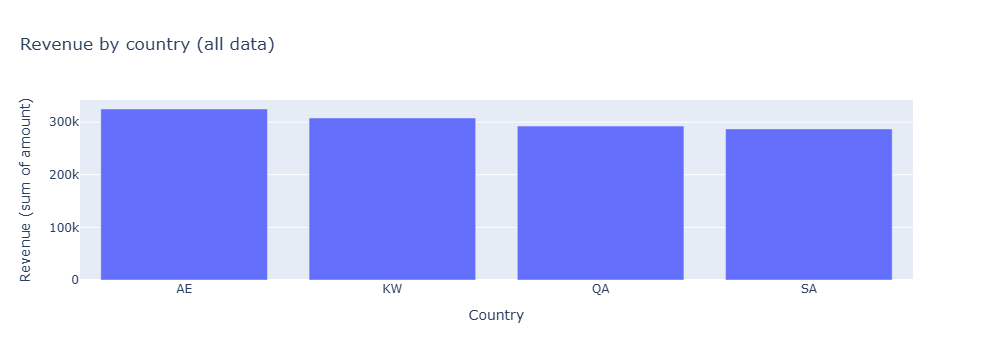

In [5]:
rev = (
    df.groupby("country", dropna=False)
      .agg(
          n=("order_id","size"),
          revenue=("amount","sum"),
          aov=("amount","mean"),
      )
      .reset_index()
      .sort_values("revenue", ascending=False)
)

fig = px.bar(rev, x="country", y="revenue", title="Revenue by country (all data)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Revenue (sum of amount)")
save_fig(fig, FIGS / "revenue_by_country.png")
fig

### Q1. Which countries generate the most orders and revenue, and what is the average order value (AOV) by country? 
The UAE (AE) generates the highest total revenue, followed by Kuwait (KW), Qatar (QA), and Saudi Arabia (SA).  
While Kuwait has the highest number of orders, the UAE achieves higher revenue due to a higher average order value (AOV).  
Overall, revenue differences across countries are present but relatively moderate.

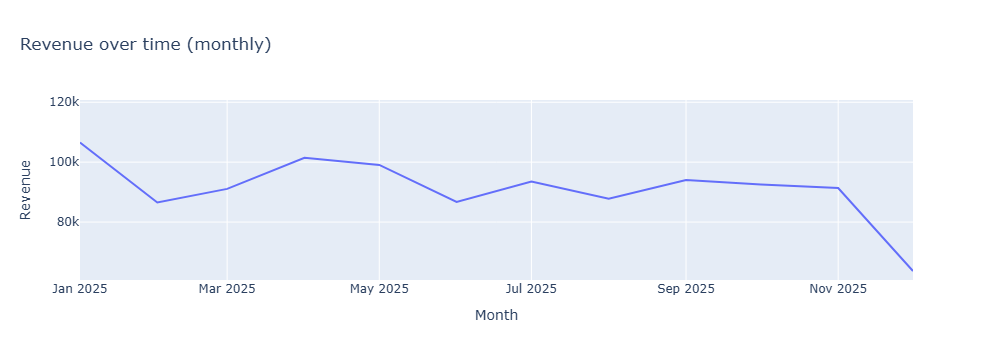

In [6]:
trend = (
    df.groupby("month", dropna=False)
      .agg(n=("order_id","size"), revenue=("amount","sum"))
      .reset_index()
      .sort_values("month")
)

fig = px.line(trend, x="month", y="revenue", title="Revenue over time (monthly)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Revenue")
save_fig(fig, FIGS / "revenue_trend_monthly.png")
fig

## Q2. How does revenue change over time on a monthly basis?
Monthly revenue fluctuates throughout the year without a clear upward or downward trend.  
Revenue peaks in January and April, then generally stabilizes with moderate variations across most months.  
A noticeable drop appears in December, which may be due to partial or incomplete data for that month.

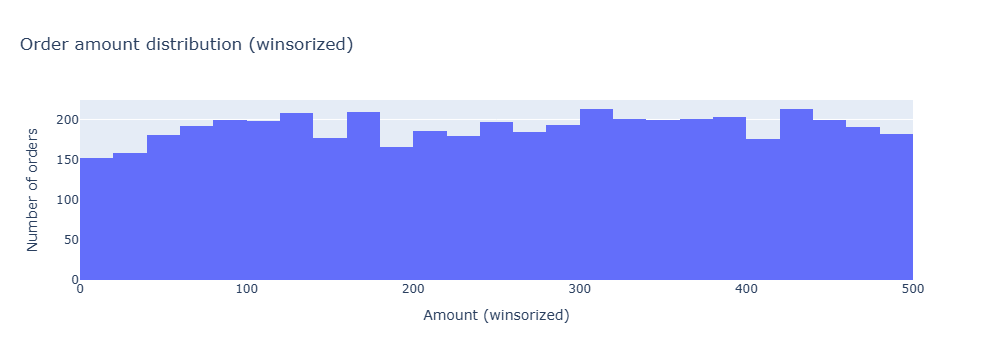

In [7]:
fig = px.histogram(df, x="amount_winsor", nbins=30, title="Order amount distribution (winsorized)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Amount (winsorized)")
fig.update_yaxes(title_text="Number of orders")
save_fig(fig, FIGS / "amount_hist_winsor.png")
fig

## Q3. What does the distribution of order amounts look like after winsorizing outliers?
After winsorizing outliers, order amounts are more evenly distributed across the range, with no extreme values dominating the distribution.  
Most orders fall within a moderate price range, indicating stable and consistent order sizes suitable for summary statistics and visualization.

In [8]:
def bootstrap_diff_means(a: pd.Series, b: pd.Series, *, n_boot: int = 2000, seed: int = 0) -> dict:
    rng = np.random.default_rng(seed)
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy()
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy()
    assert len(a) > 0 and len(b) > 0, "Empty group after cleaning"

    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    diffs = np.array(diffs)

    return {
        "diff_mean": float(a.mean() - b.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
    }

d = df.assign(is_refund=df["status_clean"].eq("refund").astype(int))

a = d.loc[d["country"].eq("SA"), "is_refund"]
b = d.loc[d["country"].eq("AE"), "is_refund"]

print("n_SA:", len(a), "n_AE:", len(b))
res = bootstrap_diff_means(a, b, n_boot=2000, seed=0)
print(res)

n_SA: 1232 n_AE: 1348
{'diff_mean': 0.020393367759836578, 'ci_low': -0.017703415834906974, 'ci_high': 0.05933074251416237}
